## 1. Обработка данных

### 1.1. Импортируем библиотеки и загружаем данные

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df=pd.read_csv('C:/Users/User/API/2.csv',sep=';',encoding='cp1252')

In [3]:
df.head()

,id,periodid,startdate,enddate,disc,isGk,isShared,isUsn,isEnvd,isBudget,...,mainSystem1420,mainSystem1421,mainSystem1422,mainSystem1423,mainSystem1424,mainSystem1425,mainSystem1426,mainSystem1427,mainSystem1428,notMainSystem
0,3,20861,01.04.2017 0:00,30.04.2017 0:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,20862,01.05.2017 0:00,31.05.2017 0:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,20864,01.06.2017 0:00,30.06.2017 0:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,20865,01.07.2017 0:00,31.07.2017 0:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3,20866,01.08.2017 0:00,31.08.2017 0:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### 1.2. Посмотрим на уникальные ID, посмотрии сколько всего клиентов в выборке

In [4]:
df.id.nunique()

4260

In [5]:
unique_id=df.id.unique()
unique_id

array([      3,      29,      42, ..., 1696323, 1696385, 1696463],
      dtype=int64)

### 1.3. Приведем даты в формат pandas и создадим новую колонку paid_time - унифицированное время оплаты счета в днях

In [6]:
df['enddate'] = pd.to_datetime(df.enddate, format='%d.%m.%Y %H:%M')
df['startdate']= pd.to_datetime(df.startdate, format='%d.%m.%Y %H:%M')
df['paid_time']= (pd.to_datetime(df.paidDate, format='%d.%m.%Y %H:%M')-df.startdate).dt.days

### 1.4. Начнем собирать данные для обучения в новом датафрейме - client_data. Для каждого уникального ID определим последний месяц сопровождения

In [7]:
client_data=df.groupby('id',as_index=False).agg({'startdate':'max'}).rename({'startdate':'last_month'},axis=1)

### 1.5. Добавим в исходный датафрейм колонку с последним месяцем обслуживания

In [8]:
df['last_month']=df.groupby(['id'])['startdate'].transform(max)

### 1.6. Определяем сущность "отколовшийся клиент". Это клиент, который не обслуживался в последний месяц. 

In [9]:
end_of_time=df.startdate.max()
end_of_time

Timestamp('2019-11-01 00:00:00')

In [10]:
client_data['is_gone']=(client_data.last_month!=end_of_time)

### 1.7. Посчитаем количество отколовшихся клиентов. Посмотрим первых 30 и проверим руками, что они действительно "отколовшиеся"

In [11]:
client_data.groupby('is_gone').count()

,id,last_month
is_gone,,
False,2834,2834
True,1426,1426


In [12]:
client_data.head(30)

,id,last_month,is_gone
0,3,2017-12-01,True
1,29,2019-11-01,False
2,42,2019-11-01,False
3,63,2019-11-01,False
4,65,2019-11-01,False
5,102,2019-11-01,False
6,108,2019-11-01,False
7,123,2019-11-01,False
8,128,2019-11-01,False
9,132,2019-11-01,False


### 1.8. В датафрейме с уникальными ID (client_data) создадим колонки, которые будут показывать изменения, произошедшие у клиента за последние 6 месяцев. Данные с датами нам уже не нужны, поэтому выключим их.

In [13]:
excepted_columns=['paidDate','startdate','enddate','last_month']

In [14]:
eps=1e-9
columns=list(set(list(df))-set('id'))
for id in unique_id:
#     print(id,end=' ')
    for col in columns:
        if col in excepted_columns:
            continue
        max_value=df.loc[(df.id==id)&(df.startdate>df.last_month-pd.Timedelta(days=182))][col].astype(float).max()
        min_value=df.loc[(df.id==id)&(df.startdate>df.last_month-pd.Timedelta(days=182))][col].astype(float).min()
        cur_value=df.loc[(df.id==id)&(df.last_month==df.startdate)][col].astype(float).max()
#         print(id,col,max_value)
        client_data.loc[client_data.id==id,col+'max']=(cur_value+eps)/(max_value+eps)
        client_data.loc[client_data.id==id,col+'min']=(cur_value+eps)/(min_value+eps)
        client_data.loc[client_data.id==id,col+'cur']=cur_value
        

In [15]:
client_data.shape

(4260, 267)

### 1.9. Заполним все пустые поля нулями

In [16]:
client_data1=client_data.fillna(0)

## 2. Теперь приступим к построению нейросети
### 2.1. Импортируем библиотеки и зададим random.seed для повторяемости результата

In [17]:
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
from torch.optim import Adam, lr_scheduler

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.backends.cudnn.deterministic = True

### 2.2. Подготовим данные для обучения

In [18]:
X=client_data1.drop(['is_gone','last_month','id'],axis=1)
y=client_data1.is_gone

In [19]:
X.shape,y.shape

((4260, 264), (4260,))

### 2.3. Разделим на тренировочную и тестовую выборку

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
X_train.shape

(3408, 264)

### 2.4. Обернем данные в тензоры

In [22]:
X_train=torch.DoubleTensor(X_train.values)
X_test=torch.DoubleTensor(X_test.values)
y_train=torch.LongTensor(y_train.values)
y_test=torch.LongTensor(y_test.values)

In [23]:
X_train.shape

torch.Size([3408, 264])

### 2.5. Зададим константы для обучения

In [28]:
batch_size=3408
lr=1e-4
num_epoch=3000
step_size=200
gamma=0.7

### 2.6. Создадим модель

In [29]:
class API_net(torch.nn.Module):
    def __init__(self):
        super(API_net,self).__init__()
        self.fc1=torch.nn.Linear(264,500)
        self.act1=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(500,500)
        self.act2=torch.nn.Tanh()
        self.fc3=torch.nn.Linear(500,2)
    
    def forward(self,x):
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.fc3(x)
        return x

model=API_net().double()

### 2.7. Запустим процесс обучения

In [30]:
model=API_net().double()
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = lr_scheduler.StepLR(optimizer,
                                step_size=step_size,
                                gamma=gamma)
    
train_accuracy_history=[]
train_loss_history=[]
test_accuracy_history=[]
test_loss_history=[]
    
for epoch in range(num_epoch):
    print()
    print('Epoch {}/{}:'.format(epoch, num_epoch - 1), flush=True)
        
    for phase in ['train','test']:
        if phase=='train':
            running_loss = 0
            running_acc = 0
            order=np.random.permutation(len(X_train))
            for start_index in range(0,len(X_train),batch_size):
                optimizer.zero_grad()
                model.train()
                batch_indexes=order[start_index:start_index+batch_size]
                X_batch=X_train[batch_indexes].to(device)
                y_batch=y_train[batch_indexes].to(device)
                preds=model.forward(X_batch)
                loss_value=loss(preds,y_batch)
                preds_class=preds.argmax(dim=1)
                loss_value.backward()
                optimizer.step()
                running_loss+=loss_value.data.cpu()
                running_acc+=(preds_class==y_batch).float().mean().data.cpu()
            train_accuracy_history.append(running_acc/(len(X_train)/batch_size))
            train_loss_history.append(running_loss/(len(X_train)/batch_size))
        else:
#             continue
            model.eval()
            preds=model.forward(X_test)
            loss_value=loss(preds,y_test).data
            preds_class=preds.argmax(dim=1)
            test_accuracy_history.append((preds_class==y_test).float().mean().data)
            test_loss_history.append(loss_value)
    print('train loss ',train_loss_history[-1])
    print('train acc  ',train_accuracy_history[-1])
    print('test loss  ',test_loss_history[-1])
    print('test acc   ',test_accuracy_history[-1])


Epoch 0/2999:
train loss  tensor(0.8355, dtype=torch.float64)
train acc   tensor(0.3991)
test loss   tensor(0.7225, dtype=torch.float64)
test acc    tensor(0.4601)

Epoch 1/2999:
train loss  tensor(0.7289, dtype=torch.float64)
train acc   tensor(0.4674)
test loss   tensor(0.6768, dtype=torch.float64)
test acc    tensor(0.5915)

Epoch 2/2999:
train loss  tensor(0.6843, dtype=torch.float64)
train acc   tensor(0.5604)
test loss   tensor(0.6772, dtype=torch.float64)
test acc    tensor(0.5458)

Epoch 3/2999:
train loss  tensor(0.6798, dtype=torch.float64)
train acc   tensor(0.5361)
test loss   tensor(0.6746, dtype=torch.float64)
test acc    tensor(0.5951)

Epoch 4/2999:
train loss  tensor(0.6784, dtype=torch.float64)
train acc   tensor(0.5883)
test loss   tensor(0.6640, dtype=torch.float64)
test acc    tensor(0.6573)

Epoch 5/2999:
train loss  tensor(0.6687, dtype=torch.float64)
train acc   tensor(0.6485)
test loss   tensor(0.6670, dtype=torch.float64)
test acc    tensor(0.6714)

Epoch 6/2

train loss  tensor(0.4591, dtype=torch.float64)
train acc   tensor(0.8281)
test loss   tensor(0.4654, dtype=torch.float64)
test acc    tensor(0.8251)

Epoch 51/2999:
train loss  tensor(0.4588, dtype=torch.float64)
train acc   tensor(0.8216)
test loss   tensor(0.4612, dtype=torch.float64)
test acc    tensor(0.8263)

Epoch 52/2999:
train loss  tensor(0.4549, dtype=torch.float64)
train acc   tensor(0.8239)
test loss   tensor(0.4609, dtype=torch.float64)
test acc    tensor(0.8251)

Epoch 53/2999:
train loss  tensor(0.4545, dtype=torch.float64)
train acc   tensor(0.8248)
test loss   tensor(0.4589, dtype=torch.float64)
test acc    tensor(0.8286)

Epoch 54/2999:
train loss  tensor(0.4534, dtype=torch.float64)
train acc   tensor(0.8286)
test loss   tensor(0.4557, dtype=torch.float64)
test acc    tensor(0.8357)

Epoch 55/2999:
train loss  tensor(0.4503, dtype=torch.float64)
train acc   tensor(0.8369)
test loss   tensor(0.4504, dtype=torch.float64)
test acc    tensor(0.8357)

Epoch 56/2999:
trai

train loss  tensor(0.3824, dtype=torch.float64)
train acc   tensor(0.8489)
test loss   tensor(0.3804, dtype=torch.float64)
test acc    tensor(0.8662)

Epoch 101/2999:
train loss  tensor(0.3803, dtype=torch.float64)
train acc   tensor(0.8492)
test loss   tensor(0.3783, dtype=torch.float64)
test acc    tensor(0.8674)

Epoch 102/2999:
train loss  tensor(0.3795, dtype=torch.float64)
train acc   tensor(0.8448)
test loss   tensor(0.3772, dtype=torch.float64)
test acc    tensor(0.8697)

Epoch 103/2999:
train loss  tensor(0.3794, dtype=torch.float64)
train acc   tensor(0.8448)
test loss   tensor(0.3758, dtype=torch.float64)
test acc    tensor(0.8697)

Epoch 104/2999:
train loss  tensor(0.3782, dtype=torch.float64)
train acc   tensor(0.8448)
test loss   tensor(0.3761, dtype=torch.float64)
test acc    tensor(0.8685)

Epoch 105/2999:
train loss  tensor(0.3783, dtype=torch.float64)
train acc   tensor(0.8445)
test loss   tensor(0.3759, dtype=torch.float64)
test acc    tensor(0.8650)

Epoch 106/2999

train loss  tensor(0.3525, dtype=torch.float64)
train acc   tensor(0.8621)
test loss   tensor(0.3487, dtype=torch.float64)
test acc    tensor(0.8744)

Epoch 151/2999:
train loss  tensor(0.3530, dtype=torch.float64)
train acc   tensor(0.8624)
test loss   tensor(0.3501, dtype=torch.float64)
test acc    tensor(0.8756)

Epoch 152/2999:
train loss  tensor(0.3532, dtype=torch.float64)
train acc   tensor(0.8627)
test loss   tensor(0.3501, dtype=torch.float64)
test acc    tensor(0.8768)

Epoch 153/2999:
train loss  tensor(0.3533, dtype=torch.float64)
train acc   tensor(0.8636)
test loss   tensor(0.3522, dtype=torch.float64)
test acc    tensor(0.8768)

Epoch 154/2999:
train loss  tensor(0.3544, dtype=torch.float64)
train acc   tensor(0.8647)
test loss   tensor(0.3526, dtype=torch.float64)
test acc    tensor(0.8697)

Epoch 155/2999:
train loss  tensor(0.3548, dtype=torch.float64)
train acc   tensor(0.8568)
test loss   tensor(0.3523, dtype=torch.float64)
test acc    tensor(0.8697)

Epoch 156/2999

train loss  tensor(0.3461, dtype=torch.float64)
train acc   tensor(0.8521)
test loss   tensor(0.3441, dtype=torch.float64)
test acc    tensor(0.8638)

Epoch 201/2999:
train loss  tensor(0.3465, dtype=torch.float64)
train acc   tensor(0.8521)
test loss   tensor(0.3442, dtype=torch.float64)
test acc    tensor(0.8650)

Epoch 202/2999:
train loss  tensor(0.3458, dtype=torch.float64)
train acc   tensor(0.8521)
test loss   tensor(0.3429, dtype=torch.float64)
test acc    tensor(0.8638)

Epoch 203/2999:
train loss  tensor(0.3446, dtype=torch.float64)
train acc   tensor(0.8518)
test loss   tensor(0.3435, dtype=torch.float64)
test acc    tensor(0.8638)

Epoch 204/2999:
train loss  tensor(0.3440, dtype=torch.float64)
train acc   tensor(0.8542)
test loss   tensor(0.3428, dtype=torch.float64)
test acc    tensor(0.8685)

Epoch 205/2999:
train loss  tensor(0.3428, dtype=torch.float64)
train acc   tensor(0.8624)
test loss   tensor(0.3420, dtype=torch.float64)
test acc    tensor(0.8697)

Epoch 206/2999

train loss  tensor(0.3265, dtype=torch.float64)
train acc   tensor(0.8671)
test loss   tensor(0.3263, dtype=torch.float64)
test acc    tensor(0.8744)

Epoch 251/2999:
train loss  tensor(0.3263, dtype=torch.float64)
train acc   tensor(0.8671)
test loss   tensor(0.3258, dtype=torch.float64)
test acc    tensor(0.8791)

Epoch 252/2999:
train loss  tensor(0.3256, dtype=torch.float64)
train acc   tensor(0.8762)
test loss   tensor(0.3250, dtype=torch.float64)
test acc    tensor(0.8791)

Epoch 253/2999:
train loss  tensor(0.3255, dtype=torch.float64)
train acc   tensor(0.8768)
test loss   tensor(0.3248, dtype=torch.float64)
test acc    tensor(0.8791)

Epoch 254/2999:
train loss  tensor(0.3250, dtype=torch.float64)
train acc   tensor(0.8773)
test loss   tensor(0.3241, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 255/2999:
train loss  tensor(0.3252, dtype=torch.float64)
train acc   tensor(0.8773)
test loss   tensor(0.3227, dtype=torch.float64)
test acc    tensor(0.8803)

Epoch 256/2999

train loss  tensor(0.3135, dtype=torch.float64)
train acc   tensor(0.8738)
test loss   tensor(0.3082, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 301/2999:
train loss  tensor(0.3133, dtype=torch.float64)
train acc   tensor(0.8732)
test loss   tensor(0.3088, dtype=torch.float64)
test acc    tensor(0.8826)

Epoch 302/2999:
train loss  tensor(0.3140, dtype=torch.float64)
train acc   tensor(0.8738)
test loss   tensor(0.3087, dtype=torch.float64)
test acc    tensor(0.8826)

Epoch 303/2999:
train loss  tensor(0.3141, dtype=torch.float64)
train acc   tensor(0.8738)
test loss   tensor(0.3088, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 304/2999:
train loss  tensor(0.3143, dtype=torch.float64)
train acc   tensor(0.8738)
test loss   tensor(0.3084, dtype=torch.float64)
test acc    tensor(0.8826)

Epoch 305/2999:
train loss  tensor(0.3137, dtype=torch.float64)
train acc   tensor(0.8738)
test loss   tensor(0.3086, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 306/2999

train loss  tensor(0.3066, dtype=torch.float64)
train acc   tensor(0.8826)
test loss   tensor(0.3007, dtype=torch.float64)
test acc    tensor(0.8897)

Epoch 351/2999:
train loss  tensor(0.3062, dtype=torch.float64)
train acc   tensor(0.8835)
test loss   tensor(0.3000, dtype=torch.float64)
test acc    tensor(0.8908)

Epoch 352/2999:
train loss  tensor(0.3055, dtype=torch.float64)
train acc   tensor(0.8844)
test loss   tensor(0.2993, dtype=torch.float64)
test acc    tensor(0.8908)

Epoch 353/2999:
train loss  tensor(0.3049, dtype=torch.float64)
train acc   tensor(0.8847)
test loss   tensor(0.3001, dtype=torch.float64)
test acc    tensor(0.8885)

Epoch 354/2999:
train loss  tensor(0.3052, dtype=torch.float64)
train acc   tensor(0.8844)
test loss   tensor(0.3000, dtype=torch.float64)
test acc    tensor(0.8897)

Epoch 355/2999:
train loss  tensor(0.3053, dtype=torch.float64)
train acc   tensor(0.8850)
test loss   tensor(0.2996, dtype=torch.float64)
test acc    tensor(0.8908)

Epoch 356/2999

train loss  tensor(0.3017, dtype=torch.float64)
train acc   tensor(0.8747)
test loss   tensor(0.2934, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 401/2999:
train loss  tensor(0.3013, dtype=torch.float64)
train acc   tensor(0.8744)
test loss   tensor(0.2942, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 402/2999:
train loss  tensor(0.3014, dtype=torch.float64)
train acc   tensor(0.8744)
test loss   tensor(0.2942, dtype=torch.float64)
test acc    tensor(0.8815)

Epoch 403/2999:
train loss  tensor(0.3013, dtype=torch.float64)
train acc   tensor(0.8753)
test loss   tensor(0.2935, dtype=torch.float64)
test acc    tensor(0.8826)

Epoch 404/2999:
train loss  tensor(0.3007, dtype=torch.float64)
train acc   tensor(0.8759)
test loss   tensor(0.2936, dtype=torch.float64)
test acc    tensor(0.8826)

Epoch 405/2999:
train loss  tensor(0.3008, dtype=torch.float64)
train acc   tensor(0.8762)
test loss   tensor(0.2937, dtype=torch.float64)
test acc    tensor(0.8838)

Epoch 406/2999

train loss  tensor(0.2944, dtype=torch.float64)
train acc   tensor(0.8870)
test loss   tensor(0.2868, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 451/2999:
train loss  tensor(0.2940, dtype=torch.float64)
train acc   tensor(0.8867)
test loss   tensor(0.2861, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 452/2999:
train loss  tensor(0.2936, dtype=torch.float64)
train acc   tensor(0.8867)
test loss   tensor(0.2863, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 453/2999:
train loss  tensor(0.2942, dtype=torch.float64)
train acc   tensor(0.8864)
test loss   tensor(0.2855, dtype=torch.float64)
test acc    tensor(0.8944)

Epoch 454/2999:
train loss  tensor(0.2934, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2860, dtype=torch.float64)
test acc    tensor(0.8944)

Epoch 455/2999:
train loss  tensor(0.2942, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2860, dtype=torch.float64)
test acc    tensor(0.8944)

Epoch 456/2999

train loss  tensor(0.2907, dtype=torch.float64)
train acc   tensor(0.8847)
test loss   tensor(0.2826, dtype=torch.float64)
test acc    tensor(0.8932)

Epoch 501/2999:
train loss  tensor(0.2918, dtype=torch.float64)
train acc   tensor(0.8847)
test loss   tensor(0.2828, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 502/2999:
train loss  tensor(0.2915, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2838, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 503/2999:
train loss  tensor(0.2914, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2823, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 504/2999:
train loss  tensor(0.2910, dtype=torch.float64)
train acc   tensor(0.8853)
test loss   tensor(0.2804, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 505/2999:
train loss  tensor(0.2897, dtype=torch.float64)
train acc   tensor(0.8850)
test loss   tensor(0.2810, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 506/2999

train loss  tensor(0.2918, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2792, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 551/2999:
train loss  tensor(0.2918, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2794, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 552/2999:
train loss  tensor(0.2919, dtype=torch.float64)
train acc   tensor(0.8894)
test loss   tensor(0.2794, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 553/2999:
train loss  tensor(0.2918, dtype=torch.float64)
train acc   tensor(0.8894)
test loss   tensor(0.2787, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 554/2999:
train loss  tensor(0.2914, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2792, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 555/2999:
train loss  tensor(0.2917, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2794, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 556/2999

train loss  tensor(0.2873, dtype=torch.float64)
train acc   tensor(0.8847)
test loss   tensor(0.2748, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 601/2999:
train loss  tensor(0.2870, dtype=torch.float64)
train acc   tensor(0.8862)
test loss   tensor(0.2746, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 602/2999:
train loss  tensor(0.2867, dtype=torch.float64)
train acc   tensor(0.8862)
test loss   tensor(0.2747, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 603/2999:
train loss  tensor(0.2868, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2747, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 604/2999:
train loss  tensor(0.2866, dtype=torch.float64)
train acc   tensor(0.8859)
test loss   tensor(0.2744, dtype=torch.float64)
test acc    tensor(0.8955)

Epoch 605/2999:
train loss  tensor(0.2865, dtype=torch.float64)
train acc   tensor(0.8856)
test loss   tensor(0.2747, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 606/2999

train loss  tensor(0.2830, dtype=torch.float64)
train acc   tensor(0.8870)
test loss   tensor(0.2706, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 651/2999:
train loss  tensor(0.2830, dtype=torch.float64)
train acc   tensor(0.8870)
test loss   tensor(0.2711, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 652/2999:
train loss  tensor(0.2830, dtype=torch.float64)
train acc   tensor(0.8867)
test loss   tensor(0.2720, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 653/2999:
train loss  tensor(0.2832, dtype=torch.float64)
train acc   tensor(0.8864)
test loss   tensor(0.2723, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 654/2999:
train loss  tensor(0.2833, dtype=torch.float64)
train acc   tensor(0.8864)
test loss   tensor(0.2718, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 655/2999:
train loss  tensor(0.2833, dtype=torch.float64)
train acc   tensor(0.8864)
test loss   tensor(0.2717, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 656/2999

train loss  tensor(0.2770, dtype=torch.float64)
train acc   tensor(0.8917)
test loss   tensor(0.2658, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 701/2999:
train loss  tensor(0.2769, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2654, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 702/2999:
train loss  tensor(0.2769, dtype=torch.float64)
train acc   tensor(0.8923)
test loss   tensor(0.2655, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 703/2999:
train loss  tensor(0.2768, dtype=torch.float64)
train acc   tensor(0.8923)
test loss   tensor(0.2653, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 704/2999:
train loss  tensor(0.2766, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2649, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 705/2999:
train loss  tensor(0.2763, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2646, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 706/2999

train loss  tensor(0.2760, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2632, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 751/2999:
train loss  tensor(0.2758, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2636, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 752/2999:
train loss  tensor(0.2761, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2633, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 753/2999:
train loss  tensor(0.2761, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2630, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 754/2999:
train loss  tensor(0.2759, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2636, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 755/2999:
train loss  tensor(0.2762, dtype=torch.float64)
train acc   tensor(0.8873)
test loss   tensor(0.2630, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 756/2999

train loss  tensor(0.2725, dtype=torch.float64)
train acc   tensor(0.8888)
test loss   tensor(0.2610, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 801/2999:
train loss  tensor(0.2724, dtype=torch.float64)
train acc   tensor(0.8897)
test loss   tensor(0.2610, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 802/2999:
train loss  tensor(0.2725, dtype=torch.float64)
train acc   tensor(0.8897)
test loss   tensor(0.2614, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 803/2999:
train loss  tensor(0.2725, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2615, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 804/2999:
train loss  tensor(0.2725, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2611, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 805/2999:
train loss  tensor(0.2724, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2613, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 806/2999

train loss  tensor(0.2694, dtype=torch.float64)
train acc   tensor(0.8908)
test loss   tensor(0.2575, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 851/2999:
train loss  tensor(0.2694, dtype=torch.float64)
train acc   tensor(0.8908)
test loss   tensor(0.2579, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 852/2999:
train loss  tensor(0.2693, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2584, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 853/2999:
train loss  tensor(0.2694, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2594, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 854/2999:
train loss  tensor(0.2700, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2594, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 855/2999:
train loss  tensor(0.2700, dtype=torch.float64)
train acc   tensor(0.8917)
test loss   tensor(0.2599, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 856/2999

train loss  tensor(0.2672, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2575, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 901/2999:
train loss  tensor(0.2671, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2578, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 902/2999:
train loss  tensor(0.2669, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2573, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 903/2999:
train loss  tensor(0.2665, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2575, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 904/2999:
train loss  tensor(0.2665, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2570, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 905/2999:
train loss  tensor(0.2664, dtype=torch.float64)
train acc   tensor(0.8941)
test loss   tensor(0.2560, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 906/2999

train loss  tensor(0.2669, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2572, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 951/2999:
train loss  tensor(0.2672, dtype=torch.float64)
train acc   tensor(0.8897)
test loss   tensor(0.2582, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 952/2999:
train loss  tensor(0.2674, dtype=torch.float64)
train acc   tensor(0.8897)
test loss   tensor(0.2573, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 953/2999:
train loss  tensor(0.2673, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2576, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 954/2999:
train loss  tensor(0.2669, dtype=torch.float64)
train acc   tensor(0.8911)
test loss   tensor(0.2578, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 955/2999:
train loss  tensor(0.2666, dtype=torch.float64)
train acc   tensor(0.8920)
test loss   tensor(0.2580, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 956/2999

train loss  tensor(0.2663, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2550, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 1000/2999:
train loss  tensor(0.2659, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 1001/2999:
train loss  tensor(0.2656, dtype=torch.float64)
train acc   tensor(0.8885)
test loss   tensor(0.2555, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 1002/2999:
train loss  tensor(0.2657, dtype=torch.float64)
train acc   tensor(0.8885)
test loss   tensor(0.2558, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 1003/2999:
train loss  tensor(0.2657, dtype=torch.float64)
train acc   tensor(0.8885)
test loss   tensor(0.2560, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 1004/2999:
train loss  tensor(0.2656, dtype=torch.float64)
train acc   tensor(0.8888)
test loss   tensor(0.2560, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 100

train loss  tensor(0.2647, dtype=torch.float64)
train acc   tensor(0.8908)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1049/2999:
train loss  tensor(0.2648, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2550, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1050/2999:
train loss  tensor(0.2647, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2548, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1051/2999:
train loss  tensor(0.2648, dtype=torch.float64)
train acc   tensor(0.8914)
test loss   tensor(0.2548, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1052/2999:
train loss  tensor(0.2647, dtype=torch.float64)
train acc   tensor(0.8917)
test loss   tensor(0.2547, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1053/2999:
train loss  tensor(0.2650, dtype=torch.float64)
train acc   tensor(0.8920)
test loss   tensor(0.2552, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 105

train loss  tensor(0.2659, dtype=torch.float64)
train acc   tensor(0.8994)
test loss   tensor(0.2591, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1098/2999:
train loss  tensor(0.2655, dtype=torch.float64)
train acc   tensor(0.9017)
test loss   tensor(0.2586, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1099/2999:
train loss  tensor(0.2655, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2585, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1100/2999:
train loss  tensor(0.2652, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2588, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1101/2999:
train loss  tensor(0.2651, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2585, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1102/2999:
train loss  tensor(0.2649, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2583, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 110

train loss  tensor(0.2622, dtype=torch.float64)
train acc   tensor(0.8999)
test loss   tensor(0.2571, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1147/2999:
train loss  tensor(0.2628, dtype=torch.float64)
train acc   tensor(0.9011)
test loss   tensor(0.2565, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1148/2999:
train loss  tensor(0.2625, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2569, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1149/2999:
train loss  tensor(0.2625, dtype=torch.float64)
train acc   tensor(0.9011)
test loss   tensor(0.2571, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1150/2999:
train loss  tensor(0.2626, dtype=torch.float64)
train acc   tensor(0.9008)
test loss   tensor(0.2574, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1151/2999:
train loss  tensor(0.2627, dtype=torch.float64)
train acc   tensor(0.9008)
test loss   tensor(0.2575, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 115

train loss  tensor(0.2625, dtype=torch.float64)
train acc   tensor(0.9008)
test loss   tensor(0.2540, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1196/2999:
train loss  tensor(0.2626, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2544, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1197/2999:
train loss  tensor(0.2623, dtype=torch.float64)
train acc   tensor(0.9011)
test loss   tensor(0.2543, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1198/2999:
train loss  tensor(0.2623, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2538, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1199/2999:
train loss  tensor(0.2623, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2538, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1200/2999:
train loss  tensor(0.2623, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2542, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 120

train loss  tensor(0.2616, dtype=torch.float64)
train acc   tensor(0.9020)
test loss   tensor(0.2542, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1245/2999:
train loss  tensor(0.2615, dtype=torch.float64)
train acc   tensor(0.9017)
test loss   tensor(0.2538, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1246/2999:
train loss  tensor(0.2612, dtype=torch.float64)
train acc   tensor(0.9017)
test loss   tensor(0.2540, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1247/2999:
train loss  tensor(0.2611, dtype=torch.float64)
train acc   tensor(0.9017)
test loss   tensor(0.2537, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1248/2999:
train loss  tensor(0.2612, dtype=torch.float64)
train acc   tensor(0.9020)
test loss   tensor(0.2537, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1249/2999:
train loss  tensor(0.2612, dtype=torch.float64)
train acc   tensor(0.9017)
test loss   tensor(0.2544, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 125

train loss  tensor(0.2619, dtype=torch.float64)
train acc   tensor(0.9002)
test loss   tensor(0.2543, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1294/2999:
train loss  tensor(0.2626, dtype=torch.float64)
train acc   tensor(0.8982)
test loss   tensor(0.2540, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1295/2999:
train loss  tensor(0.2620, dtype=torch.float64)
train acc   tensor(0.8996)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 1296/2999:
train loss  tensor(0.2619, dtype=torch.float64)
train acc   tensor(0.8994)
test loss   tensor(0.2541, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1297/2999:
train loss  tensor(0.2615, dtype=torch.float64)
train acc   tensor(0.8996)
test loss   tensor(0.2540, dtype=torch.float64)
test acc    tensor(0.9073)

Epoch 1298/2999:
train loss  tensor(0.2618, dtype=torch.float64)
train acc   tensor(0.8996)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 129

train loss  tensor(0.2651, dtype=torch.float64)
train acc   tensor(0.8867)
test loss   tensor(0.2580, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 1343/2999:
train loss  tensor(0.2646, dtype=torch.float64)
train acc   tensor(0.8873)
test loss   tensor(0.2578, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 1344/2999:
train loss  tensor(0.2648, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2583, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 1345/2999:
train loss  tensor(0.2657, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2583, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 1346/2999:
train loss  tensor(0.2651, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2603, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 1347/2999:
train loss  tensor(0.2677, dtype=torch.float64)
train acc   tensor(0.8876)
test loss   tensor(0.2584, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 134

train loss  tensor(0.2684, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2554, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1392/2999:
train loss  tensor(0.2687, dtype=torch.float64)
train acc   tensor(0.8894)
test loss   tensor(0.2566, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 1393/2999:
train loss  tensor(0.2694, dtype=torch.float64)
train acc   tensor(0.8894)
test loss   tensor(0.2557, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 1394/2999:
train loss  tensor(0.2684, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2554, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 1395/2999:
train loss  tensor(0.2689, dtype=torch.float64)
train acc   tensor(0.8888)
test loss   tensor(0.2550, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 1396/2999:
train loss  tensor(0.2688, dtype=torch.float64)
train acc   tensor(0.8885)
test loss   tensor(0.2544, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 139

train loss  tensor(0.2681, dtype=torch.float64)
train acc   tensor(0.8888)
test loss   tensor(0.2537, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 1441/2999:
train loss  tensor(0.2684, dtype=torch.float64)
train acc   tensor(0.8891)
test loss   tensor(0.2527, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 1442/2999:
train loss  tensor(0.2680, dtype=torch.float64)
train acc   tensor(0.8917)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1443/2999:
train loss  tensor(0.2674, dtype=torch.float64)
train acc   tensor(0.8923)
test loss   tensor(0.2518, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 1444/2999:
train loss  tensor(0.2673, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2523, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1445/2999:
train loss  tensor(0.2669, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2533, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 144

train loss  tensor(0.2655, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2507, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1490/2999:
train loss  tensor(0.2650, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2504, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1491/2999:
train loss  tensor(0.2646, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2525, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1492/2999:
train loss  tensor(0.2663, dtype=torch.float64)
train acc   tensor(0.8923)
test loss   tensor(0.2533, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1493/2999:
train loss  tensor(0.2667, dtype=torch.float64)
train acc   tensor(0.8923)
test loss   tensor(0.2534, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1494/2999:
train loss  tensor(0.2670, dtype=torch.float64)
train acc   tensor(0.8894)
test loss   tensor(0.2533, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 149

train loss  tensor(0.2654, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 1539/2999:
train loss  tensor(0.2655, dtype=torch.float64)
train acc   tensor(0.8903)
test loss   tensor(0.2520, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1540/2999:
train loss  tensor(0.2656, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2524, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1541/2999:
train loss  tensor(0.2657, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2526, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1542/2999:
train loss  tensor(0.2658, dtype=torch.float64)
train acc   tensor(0.8897)
test loss   tensor(0.2525, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1543/2999:
train loss  tensor(0.2655, dtype=torch.float64)
train acc   tensor(0.8900)
test loss   tensor(0.2521, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 154

train loss  tensor(0.2611, dtype=torch.float64)
train acc   tensor(0.8935)
test loss   tensor(0.2497, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1588/2999:
train loss  tensor(0.2611, dtype=torch.float64)
train acc   tensor(0.8935)
test loss   tensor(0.2500, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1589/2999:
train loss  tensor(0.2613, dtype=torch.float64)
train acc   tensor(0.8935)
test loss   tensor(0.2498, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1590/2999:
train loss  tensor(0.2612, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2502, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1591/2999:
train loss  tensor(0.2614, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2501, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1592/2999:
train loss  tensor(0.2615, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2500, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 159

train loss  tensor(0.2607, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2472, dtype=torch.float64)
test acc    tensor(0.9073)

Epoch 1637/2999:
train loss  tensor(0.2608, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2485, dtype=torch.float64)
test acc    tensor(0.9073)

Epoch 1638/2999:
train loss  tensor(0.2617, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2484, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1639/2999:
train loss  tensor(0.2615, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1640/2999:
train loss  tensor(0.2611, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2485, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 1641/2999:
train loss  tensor(0.2612, dtype=torch.float64)
train acc   tensor(0.8941)
test loss   tensor(0.2487, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 164

train loss  tensor(0.2606, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2469, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1686/2999:
train loss  tensor(0.2600, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 1687/2999:
train loss  tensor(0.2601, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2483, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 1688/2999:
train loss  tensor(0.2599, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2481, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1689/2999:
train loss  tensor(0.2599, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2489, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 1690/2999:
train loss  tensor(0.2605, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 169

train loss  tensor(0.2592, dtype=torch.float64)
train acc   tensor(0.8938)
test loss   tensor(0.2485, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1735/2999:
train loss  tensor(0.2590, dtype=torch.float64)
train acc   tensor(0.8935)
test loss   tensor(0.2480, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1736/2999:
train loss  tensor(0.2587, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2476, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1737/2999:
train loss  tensor(0.2586, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2483, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1738/2999:
train loss  tensor(0.2595, dtype=torch.float64)
train acc   tensor(0.8929)
test loss   tensor(0.2476, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1739/2999:
train loss  tensor(0.2587, dtype=torch.float64)
train acc   tensor(0.8926)
test loss   tensor(0.2478, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 174

train loss  tensor(0.2604, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2496, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1784/2999:
train loss  tensor(0.2602, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2499, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1785/2999:
train loss  tensor(0.2600, dtype=torch.float64)
train acc   tensor(0.9032)
test loss   tensor(0.2498, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1786/2999:
train loss  tensor(0.2601, dtype=torch.float64)
train acc   tensor(0.9023)
test loss   tensor(0.2497, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1787/2999:
train loss  tensor(0.2599, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2499, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1788/2999:
train loss  tensor(0.2599, dtype=torch.float64)
train acc   tensor(0.9032)
test loss   tensor(0.2498, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 178

train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.9049)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1833/2999:
train loss  tensor(0.2564, dtype=torch.float64)
train acc   tensor(0.9049)
test loss   tensor(0.2480, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 1834/2999:
train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.9046)
test loss   tensor(0.2470, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 1835/2999:
train loss  tensor(0.2559, dtype=torch.float64)
train acc   tensor(0.9046)
test loss   tensor(0.2466, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 1836/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.9046)
test loss   tensor(0.2461, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 1837/2999:
train loss  tensor(0.2559, dtype=torch.float64)
train acc   tensor(0.9043)
test loss   tensor(0.2455, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 183

train loss  tensor(0.2592, dtype=torch.float64)
train acc   tensor(0.9032)
test loss   tensor(0.2498, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1882/2999:
train loss  tensor(0.2590, dtype=torch.float64)
train acc   tensor(0.9032)
test loss   tensor(0.2503, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1883/2999:
train loss  tensor(0.2591, dtype=torch.float64)
train acc   tensor(0.9035)
test loss   tensor(0.2506, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 1884/2999:
train loss  tensor(0.2592, dtype=torch.float64)
train acc   tensor(0.9035)
test loss   tensor(0.2504, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1885/2999:
train loss  tensor(0.2591, dtype=torch.float64)
train acc   tensor(0.9035)
test loss   tensor(0.2502, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 1886/2999:
train loss  tensor(0.2590, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2503, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 188

train loss  tensor(0.2591, dtype=torch.float64)
train acc   tensor(0.9023)
test loss   tensor(0.2523, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1931/2999:
train loss  tensor(0.2592, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2520, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1932/2999:
train loss  tensor(0.2595, dtype=torch.float64)
train acc   tensor(0.9014)
test loss   tensor(0.2513, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1933/2999:
train loss  tensor(0.2590, dtype=torch.float64)
train acc   tensor(0.9011)
test loss   tensor(0.2514, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1934/2999:
train loss  tensor(0.2587, dtype=torch.float64)
train acc   tensor(0.8908)
test loss   tensor(0.2522, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 1935/2999:
train loss  tensor(0.2591, dtype=torch.float64)
train acc   tensor(0.8906)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 193

train loss  tensor(0.2570, dtype=torch.float64)
train acc   tensor(0.9026)
test loss   tensor(0.2531, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 1980/2999:
train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.9023)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1981/2999:
train loss  tensor(0.2571, dtype=torch.float64)
train acc   tensor(0.9026)
test loss   tensor(0.2508, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1982/2999:
train loss  tensor(0.2578, dtype=torch.float64)
train acc   tensor(0.9020)
test loss   tensor(0.2508, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1983/2999:
train loss  tensor(0.2581, dtype=torch.float64)
train acc   tensor(0.9023)
test loss   tensor(0.2501, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 1984/2999:
train loss  tensor(0.2574, dtype=torch.float64)
train acc   tensor(0.9023)
test loss   tensor(0.2505, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 198

train loss  tensor(0.2564, dtype=torch.float64)
train acc   tensor(0.8955)
test loss   tensor(0.2527, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2029/2999:
train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2518, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2030/2999:
train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.8958)
test loss   tensor(0.2516, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2031/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2513, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2032/2999:
train loss  tensor(0.2562, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2033/2999:
train loss  tensor(0.2560, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2518, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 203

train loss  tensor(0.2583, dtype=torch.float64)
train acc   tensor(0.9070)
test loss   tensor(0.2541, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2078/2999:
train loss  tensor(0.2579, dtype=torch.float64)
train acc   tensor(0.9064)
test loss   tensor(0.2536, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 2079/2999:
train loss  tensor(0.2577, dtype=torch.float64)
train acc   tensor(0.9064)
test loss   tensor(0.2533, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 2080/2999:
train loss  tensor(0.2573, dtype=torch.float64)
train acc   tensor(0.9067)
test loss   tensor(0.2538, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 2081/2999:
train loss  tensor(0.2574, dtype=torch.float64)
train acc   tensor(0.9061)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2082/2999:
train loss  tensor(0.2582, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2553, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 208

train loss  tensor(0.2562, dtype=torch.float64)
train acc   tensor(0.9058)
test loss   tensor(0.2541, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2127/2999:
train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2538, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 2128/2999:
train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.8941)
test loss   tensor(0.2535, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2129/2999:
train loss  tensor(0.2566, dtype=torch.float64)
train acc   tensor(0.8941)
test loss   tensor(0.2541, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2130/2999:
train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2545, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2131/2999:
train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.8955)
test loss   tensor(0.2545, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 213

train loss  tensor(0.2549, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2511, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2176/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2514, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2177/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2514, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2178/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2515, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2179/2999:
train loss  tensor(0.2545, dtype=torch.float64)
train acc   tensor(0.9058)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2180/2999:
train loss  tensor(0.2543, dtype=torch.float64)
train acc   tensor(0.9058)
test loss   tensor(0.2517, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 218

train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9049)
test loss   tensor(0.2549, dtype=torch.float64)
test acc    tensor(0.9096)

Epoch 2225/2999:
train loss  tensor(0.2548, dtype=torch.float64)
train acc   tensor(0.9046)
test loss   tensor(0.2561, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 2226/2999:
train loss  tensor(0.2558, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2563, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2227/2999:
train loss  tensor(0.2557, dtype=torch.float64)
train acc   tensor(0.8947)
test loss   tensor(0.2570, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2228/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.8944)
test loss   tensor(0.2560, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2229/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.8932)
test loss   tensor(0.2559, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 223

train loss  tensor(0.2593, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2504, dtype=torch.float64)
test acc    tensor(0.9073)

Epoch 2274/2999:
train loss  tensor(0.2591, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2516, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2275/2999:
train loss  tensor(0.2597, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2529, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2276/2999:
train loss  tensor(0.2590, dtype=torch.float64)
train acc   tensor(0.8955)
test loss   tensor(0.2543, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2277/2999:
train loss  tensor(0.2605, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2542, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2278/2999:
train loss  tensor(0.2611, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2546, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 227

train loss  tensor(0.2556, dtype=torch.float64)
train acc   tensor(0.9079)
test loss   tensor(0.2492, dtype=torch.float64)
test acc    tensor(0.9178)

Epoch 2323/2999:
train loss  tensor(0.2554, dtype=torch.float64)
train acc   tensor(0.9082)
test loss   tensor(0.2496, dtype=torch.float64)
test acc    tensor(0.9178)

Epoch 2324/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.9085)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 2325/2999:
train loss  tensor(0.2555, dtype=torch.float64)
train acc   tensor(0.9087)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 2326/2999:
train loss  tensor(0.2559, dtype=torch.float64)
train acc   tensor(0.9087)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 2327/2999:
train loss  tensor(0.2557, dtype=torch.float64)
train acc   tensor(0.9087)
test loss   tensor(0.2493, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 232

train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.9079)
test loss   tensor(0.2478, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 2372/2999:
train loss  tensor(0.2567, dtype=torch.float64)
train acc   tensor(0.9082)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 2373/2999:
train loss  tensor(0.2565, dtype=torch.float64)
train acc   tensor(0.9076)
test loss   tensor(0.2487, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 2374/2999:
train loss  tensor(0.2572, dtype=torch.float64)
train acc   tensor(0.9079)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 2375/2999:
train loss  tensor(0.2566, dtype=torch.float64)
train acc   tensor(0.9082)
test loss   tensor(0.2475, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 2376/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.9082)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 237

train loss  tensor(0.2547, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2504, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2421/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2509, dtype=torch.float64)
test acc    tensor(0.9131)

Epoch 2422/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.9055)
test loss   tensor(0.2506, dtype=torch.float64)
test acc    tensor(0.9155)

Epoch 2423/2999:
train loss  tensor(0.2553, dtype=torch.float64)
train acc   tensor(0.9052)
test loss   tensor(0.2513, dtype=torch.float64)
test acc    tensor(0.9167)

Epoch 2424/2999:
train loss  tensor(0.2551, dtype=torch.float64)
train acc   tensor(0.9061)
test loss   tensor(0.2502, dtype=torch.float64)
test acc    tensor(0.9178)

Epoch 2425/2999:
train loss  tensor(0.2547, dtype=torch.float64)
train acc   tensor(0.9064)
test loss   tensor(0.2495, dtype=torch.float64)
test acc    tensor(0.9190)

Epoch 242

train loss  tensor(0.2573, dtype=torch.float64)
train acc   tensor(0.8906)
test loss   tensor(0.2471, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2470/2999:
train loss  tensor(0.2566, dtype=torch.float64)
train acc   tensor(0.8935)
test loss   tensor(0.2468, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 2471/2999:
train loss  tensor(0.2563, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2472, dtype=torch.float64)
test acc    tensor(0.9120)

Epoch 2472/2999:
train loss  tensor(0.2564, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2478, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 2473/2999:
train loss  tensor(0.2564, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9108)

Epoch 2474/2999:
train loss  tensor(0.2568, dtype=torch.float64)
train acc   tensor(0.9029)
test loss   tensor(0.2481, dtype=torch.float64)
test acc    tensor(0.9143)

Epoch 247

train loss  tensor(0.2562, dtype=torch.float64)
train acc   tensor(0.9082)
test loss   tensor(0.2504, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2519/2999:
train loss  tensor(0.2566, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2502, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2520/2999:
train loss  tensor(0.2561, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2509, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2521/2999:
train loss  tensor(0.2562, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2510, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2522/2999:
train loss  tensor(0.2556, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2495, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2523/2999:
train loss  tensor(0.2556, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2499, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 252

train loss  tensor(0.2549, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2515, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2568/2999:
train loss  tensor(0.2550, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2508, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2569/2999:
train loss  tensor(0.2548, dtype=torch.float64)
train acc   tensor(0.8950)
test loss   tensor(0.2500, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2570/2999:
train loss  tensor(0.2544, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2509, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2571/2999:
train loss  tensor(0.2541, dtype=torch.float64)
train acc   tensor(0.8952)
test loss   tensor(0.2507, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2572/2999:
train loss  tensor(0.2540, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2515, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 257

train loss  tensor(0.2513, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 2617/2999:
train loss  tensor(0.2511, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2484, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 2618/2999:
train loss  tensor(0.2514, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2485, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 2619/2999:
train loss  tensor(0.2515, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2483, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 2620/2999:
train loss  tensor(0.2521, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2499, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 2621/2999:
train loss  tensor(0.2540, dtype=torch.float64)
train acc   tensor(0.8967)
test loss   tensor(0.2501, dtype=torch.float64)
test acc    tensor(0.9085)

Epoch 262

train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8967)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9061)

Epoch 2666/2999:
train loss  tensor(0.2511, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2667/2999:
train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2481, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2668/2999:
train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2483, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2669/2999:
train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2483, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2670/2999:
train loss  tensor(0.2508, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2485, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 267

train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2470, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2715/2999:
train loss  tensor(0.2509, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2467, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2716/2999:
train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8958)
test loss   tensor(0.2466, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2717/2999:
train loss  tensor(0.2510, dtype=torch.float64)
train acc   tensor(0.8958)
test loss   tensor(0.2458, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2718/2999:
train loss  tensor(0.2504, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2446, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 2719/2999:
train loss  tensor(0.2502, dtype=torch.float64)
train acc   tensor(0.8961)
test loss   tensor(0.2451, dtype=torch.float64)
test acc    tensor(0.9049)

Epoch 272

train loss  tensor(0.2492, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2480, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2764/2999:
train loss  tensor(0.2493, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2765/2999:
train loss  tensor(0.2489, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2479, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2766/2999:
train loss  tensor(0.2488, dtype=torch.float64)
train acc   tensor(0.8976)
test loss   tensor(0.2480, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2767/2999:
train loss  tensor(0.2488, dtype=torch.float64)
train acc   tensor(0.8976)
test loss   tensor(0.2480, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2768/2999:
train loss  tensor(0.2487, dtype=torch.float64)
train acc   tensor(0.8976)
test loss   tensor(0.2482, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 276

train loss  tensor(0.2497, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2476, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2813/2999:
train loss  tensor(0.2494, dtype=torch.float64)
train acc   tensor(0.8967)
test loss   tensor(0.2478, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2814/2999:
train loss  tensor(0.2496, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2815/2999:
train loss  tensor(0.2496, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2477, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2816/2999:
train loss  tensor(0.2495, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2474, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2817/2999:
train loss  tensor(0.2496, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2476, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 281

train loss  tensor(0.2493, dtype=torch.float64)
train acc   tensor(0.8967)
test loss   tensor(0.2488, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2862/2999:
train loss  tensor(0.2494, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2492, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2863/2999:
train loss  tensor(0.2497, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2496, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2864/2999:
train loss  tensor(0.2496, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2495, dtype=torch.float64)
test acc    tensor(0.9038)

Epoch 2865/2999:
train loss  tensor(0.2494, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2494, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2866/2999:
train loss  tensor(0.2493, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2489, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 286

train loss  tensor(0.2490, dtype=torch.float64)
train acc   tensor(0.8976)
test loss   tensor(0.2494, dtype=torch.float64)
test acc    tensor(0.9014)

Epoch 2911/2999:
train loss  tensor(0.2489, dtype=torch.float64)
train acc   tensor(0.8982)
test loss   tensor(0.2497, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2912/2999:
train loss  tensor(0.2488, dtype=torch.float64)
train acc   tensor(0.8988)
test loss   tensor(0.2496, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2913/2999:
train loss  tensor(0.2489, dtype=torch.float64)
train acc   tensor(0.8982)
test loss   tensor(0.2495, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2914/2999:
train loss  tensor(0.2487, dtype=torch.float64)
train acc   tensor(0.8988)
test loss   tensor(0.2491, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 2915/2999:
train loss  tensor(0.2489, dtype=torch.float64)
train acc   tensor(0.8988)
test loss   tensor(0.2496, dtype=torch.float64)
test acc    tensor(0.9026)

Epoch 291

train loss  tensor(0.2478, dtype=torch.float64)
train acc   tensor(0.8973)
test loss   tensor(0.2487, dtype=torch.float64)
test acc    tensor(0.9002)

Epoch 2960/2999:
train loss  tensor(0.2478, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2497, dtype=torch.float64)
test acc    tensor(0.8944)

Epoch 2961/2999:
train loss  tensor(0.2479, dtype=torch.float64)
train acc   tensor(0.8964)
test loss   tensor(0.2491, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 2962/2999:
train loss  tensor(0.2478, dtype=torch.float64)
train acc   tensor(0.8967)
test loss   tensor(0.2486, dtype=torch.float64)
test acc    tensor(0.8991)

Epoch 2963/2999:
train loss  tensor(0.2477, dtype=torch.float64)
train acc   tensor(0.8970)
test loss   tensor(0.2486, dtype=torch.float64)
test acc    tensor(0.8979)

Epoch 2964/2999:
train loss  tensor(0.2479, dtype=torch.float64)
train acc   tensor(0.8958)
test loss   tensor(0.2487, dtype=torch.float64)
test acc    tensor(0.8967)

Epoch 296

### 2.8. Построим графики

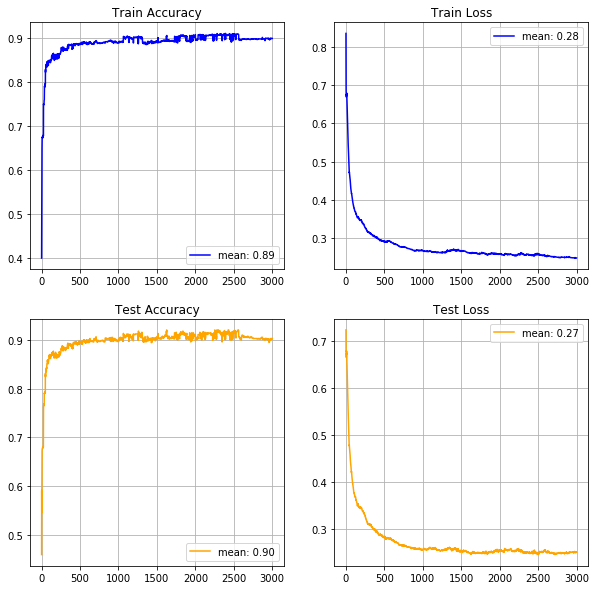

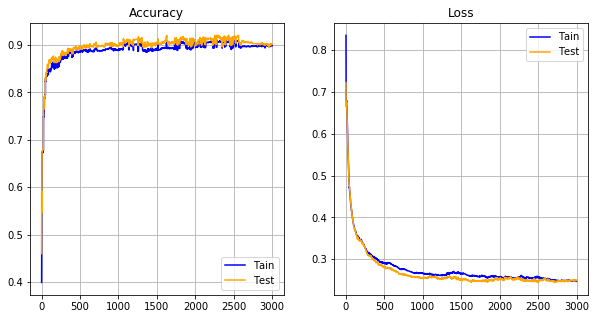

In [31]:
from matplotlib import pyplot as plt
history=[train_accuracy_history,train_loss_history,test_accuracy_history,test_loss_history]
titles = ['Train Accuracy', 'Train Loss', 'Test Accuracy', 'Test Loss']
plt.figure(figsize=(10, 10))
for i, image in enumerate(history):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    if i == 0 or i == 1:
        color = 'b'
    else:
        color = 'orange'
    plt.plot(image,c=color, label= 'mean: %.2f' % np.array(image).mean())
    plt.legend(loc='best')
plt.show()

titles_ = ['Accuracy','Loss']
plt.figure(figsize=(10, 5))
k=0
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(history[0+k], label='Tain', c='b')
    plt.plot(history[2+k], label='Test', c='orange')
    plt.title(titles_[i])
    plt.grid()
    plt.legend(loc='best')
    k += 1


### 2.9. Построим ROC кривую

In [32]:
preds=model.forward(X_test)
m = torch.nn.Softmax(dim=1)
y_predicted=m(preds)
y_predicted=y_predicted.detach().numpy()

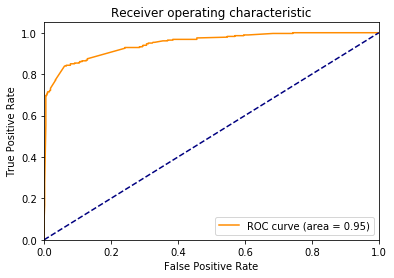

In [33]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()